In [1]:
import numpy as np
import xarray as xr
import pandas as pd

from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
from scipy.interpolate import NearestNDInterpolator

# Creating HWRF Plots
---
## 1. Get Paths 
- 1.1 Define relevant paths
- 1.2 Define getTime() for future convenience
- 1.3 Define a .tpc file reader to find lat,lon of center of given storm at given hour

#### 1.1 Define relevant paths

In [2]:
#get paths; for nc paths, omit the last .f___.nc
ncPath1 = '/data2/qy2216/HWRF_wind/hwrf.2021072718/nepartak11w/nc/nepartak11w.2021072718'
tpcPath1 = '/data2/qy2216/HWRF_wind/hwrf.2021072718/nepartak11w/track/NEPARTAK11W.2021072718.stats.tpc'

ncPath2 = '/data2/qy2216/HWRF_wind/hwrf.2021102118/invest92e/nc/invest92e.2021102118'
tpcPath2 = '/data2/qy2216/HWRF_wind/hwrf.2021102118/invest92e/track/INVEST92E.2021102118.stats.tpc'

ncPath3 = '/data2/qy2216/HWRF_wind/hwrf.2021073006/invest90e/nc/invest90e.2021073006'
tpcPath3 = '/data2/qy2216/HWRF_wind/hwrf.2021073006/invest90e/track/INVEST90E.2021073006.stats.tpc'

#### 1.2 Define getTime() for future convenience

In [3]:
def getTime(ncPath):
    return ncPath[-10:]

time1 = getTime(ncPath1)
time2 = getTime(ncPath2)
time3 = getTime(ncPath3)

#define start and end hours of data
startHour = 0
endHour = 33
stepHour = 3
numData = (endHour-startHour)//stepHour

#### 1.3 Define a .tpc file reader to find lat,lon of center of given storm at given hour

In [4]:
#read .tpc files
colspecs = [(5, 10), (18, 25), (32, 38), (56, 63), (89, 95)]

def readTPC(tpc):
    colspecs = [(5, 10), (18, 25), (32, 38), (56, 63), (89, 95)]
    df = pd.read_fwf(tpc, colspecs=colspecs, header=None, skiprows=12, names=['hour', 'lon', 'lat', 'P', 'V'])
    df = df[:df.loc[df['hour'] == 'ORECA'].index[0]] #find where the df ends (based on "FORECAST" which is written directly after the last line of each .tpc df)
    df['hour'] = df['hour'].astype(float)
    df['lat'] = df['lat'].astype(float)
    df['lon'] = df['lon'].astype(float)
    return df

---
## 2. Create Polar Plots for each Hour of Storm 
- 2.1 Create Polar Grid
- 2.2 Define function to interpolate onto polar grid
    - Center the data with data from .tpc file (1)
    - Use NearestNDInterpolator to interpolate onto Polar Grid
- 2.3 Loop Over Datasets to Prepare and Plot Data

#### 2.1 Create Polar Grid

In [5]:
#create polar grid
ntheta_pts = 201
nr_pts = 200
rmax = 300

#FIX rmax name
r1 = np.linspace(0, rmax, nr_pts)
theta1 = np.linspace(-np.pi, np.pi, ntheta_pts)

theta2, r2 = np.meshgrid(theta1, r1)

# cartesian coordinates (in km) of the polar coordinates
polar_x2 = r2 * np.cos(theta2)
polar_y2 = r2 * np.sin(theta2)

#### 2.2 Define function to interpolate

In [6]:
#Create Interpolate Function

def makeInterpPolar(dsi, i, tpcPath, gridx = polar_x2, gridy = polar_y2):
    zi = dsi.APCP_surface.isel(time=0).values
    loni = dsi.longitude.values
    lati = dsi.latitude.values
    df = readTPC(tpcPath)
    xcenteri = df[df.hour == i].lon.values[0]
    ycenteri = df[df.hour == i].lat.values[0]
    xi1 = (loni - xcenteri)*np.cos(np.deg2rad(ycenteri))*110.567
    yi1 = (lati - ycenteri)*110.567
    xi2,yi2 = np.meshgrid(xi1,yi1)
    # number of points X 2 matrix of x y
    xyi = np.stack((xi2.flatten(), yi2.flatten())).T

    interpi = NearestNDInterpolator(xyi, zi.flatten())
    Zi = interpi(gridx, gridy)
    return Zi

#### 2.3 Loop Over Datasets to Prepare and Plot Data

In [7]:
def plotPolar(t,Z,hour):
    plt.figure()
    plt.subplot(projection="polar")
    plt.pcolormesh(theta1, r1, Z, shading='gouraud')
    plt.plot(0, 0, 'rx', label='center')
    plt.title(str(t) + ": Hour " + hour)
    plt.legend()

In [8]:
#Loop and plot multiple hours of the storm

def plotMultiplePolar(t,ncPath,tpcPath):
    for i,j in enumerate(range(startHour,endHour,stepHour)):
        #print('%03d' % i)
        hour = '%03d' % j
        ds = xr.open_dataset(ncPath+'.f'+hour+'.nc')
        Z = makeInterpPolar(ds, j, tpcPath)
        plotPolar(t,Z,hour)

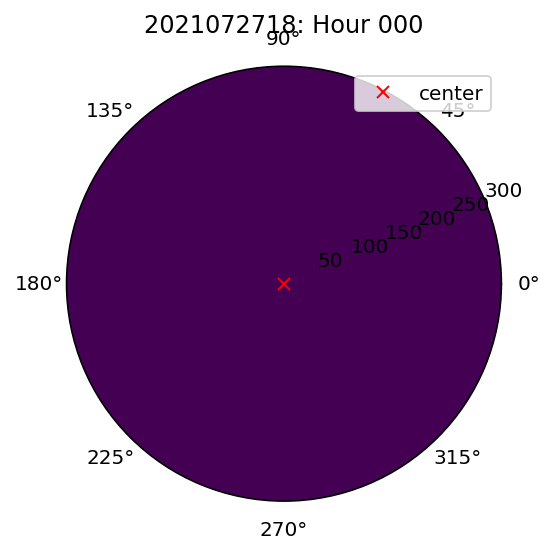

In [ ]:
plotMultiplePolar(time1,ncPath1,tpcPath1)
plt.gca().set_aspect('equal')
plt.show()

---
## 3. Superimposed Plot of Centered Data
- 3.1 Define function to calculate cumulative centered data
    - Make array containing the datasets from startHour to endHour
    - Use np.sum() to find total rainfall
- 3.2 Create plot for cumulative (superimposed) centered data
- 3.3 Create plot for mean rainfall rates (mrr) (figure 11 of 2004 Lonfat et al.) -- as a function of storm intensity (V)
    - 3.3.1 Sort data into respective intensities
    - 3.3.2 If we have storm data in a given intensity, plot mrr for the given intensity

#### 3.1 Define function to calculate cumulative centered data

In [ ]:
#make array containing the datasets from startHour to endHour

def findTotalCenteredPolar(t,ncPath,tpcPath):
    dataarray = np.zeros(numData, dtype=np.ndarray)
    for i,j in enumerate(range(startHour,endHour,stepHour)):
        hour = '%03d' % j  
        ds = xr.open_dataset(ncPath+'.f'+ hour+'.nc')
        dataarray[i] = makeInterpPolar(ds, j, tpcPath) 

    #find total rainfall
    centeredCum = np.sum(dataarray, axis=0)
    return dataarray, centeredCum

#### 3.2 Create plot for cumulative (superimposed) centered data

In [ ]:
def plotTotalCenteredPolar(t,centeredCum):
    #Plot total rainfall
    plt.figure()
    plt.subplot(projection="polar")
    plt.pcolormesh(theta1, r1, centeredCum, shading='gouraud')
    plt.plot(0, 0, 'rx', label='center')
    plt.title("Superimposed Centered Data: " + str(t))
    plt.legend()

    plt.gca().set_aspect('equal')
    plt.show()

In [ ]:
centeredCum1 = findTotalCenteredPolar(time1,ncPath1,tpcPath1)[1]
plotTotalCenteredPolar(time1,centeredCum1)

centeredCum2 = findTotalCenteredPolar(time2,ncPath2,tpcPath2)[1]
plotTotalCenteredPolar(time2,centeredCum2)

centeredCum3 = findTotalCenteredPolar(time3,ncPath3,tpcPath3)[1]
plotTotalCenteredPolar(time3,centeredCum3)

#### 3.3 Create plot for mean rainfall rates (figure 11 of 2004 Lonfat et al.)
- Plot mean rainfall rates (mrr) as a function of storm intensity (V)
    - 3.3.1 Sort data into respective intensities
    - 3.3.2 If we have storm data in a given intensity, plot mrr for the given intensity

###### 3.3.1 Sort data by storm intensity and create respective arrays containing cumulative data

In [ ]:
#returns lists with indices of the hours during which the storm is a particular category
def sortIntensity(tpcPath):
    df = readTPC(tpcPath)
    intensity = df.V
    TS = []
    CAT12 = []
    CAT35 = []
    for i,j in enumerate(df.V[0:numData]):
        if (j>=18 and j<34):
            TS.append(i)
        if (j>=34 and j<49):
            CAT12.append(i)
        if (j>=49):
            CAT35.append(i)
    return TS,CAT12,CAT35

In [ ]:
def findTotalCenteredPolarSorted(t,ncPath,tpcPath):
    tsi, cat12i, cat35i = sortIntensity(tpcPath)
    TSdata = np.zeros(len(tsi), dtype=np.ndarray)
    cat12data = np.zeros(len(cat12i), dtype=np.ndarray)
    cat35data = np.zeros(len(cat35i), dtype=np.ndarray)
    tscounter = 0 
    cat12counter = 0
    cat35counter = 0
    for i,j in enumerate(range(startHour,endHour,stepHour)):
        hour = '%03d' % j  
        ds = xr.open_dataset(ncPath+'.f'+ hour+'.nc')
        if i in tsi:
            TSdata[tscounter] = makeInterpPolar(ds, j, tpcPath) 
            tscounter += 1
        if i in cat12i:
            cat12data[cat12counter] = makeInterpPolar(ds, j, tpcPath) 
            cat12counter += 1
        if i in cat35i:
            cat35data[cat35counter] = makeInterpPolar(ds, j, tpcPath)
            cat35counter += 1

    centeredCumTs = np.sum(TSdata, axis=0)
    centeredCumCat12 = np.sum(cat12data, axis=0)
    centeredCumCat35 = np.sum(cat35data, axis=0)
    return [centeredCumTs,len(tsi)], [centeredCumCat12,len(cat12i)], [centeredCumCat35,len(cat35i)]

###### 3.3.2 Plot mrr for cumulative + given storm intensities

In [ ]:
def plotMeanRainfallRateV(t,ds,ts,cat12,cat35):
    meanRainfall = np.mean(ds, axis=1)/numData
    plt.figure()
    plt.scatter(r1,meanRainfall,s=3, label = "Cumulative: " + str(t))
    
    if isinstance(ts[0],np.ndarray):
        meanRainfallTs = np.mean(ts[0], axis=1)/ts[1]
        plt.scatter(r1,meanRainfallTs,s=3, label = "TS")
    if isinstance(cat12[0],np.ndarray):
        meanRainfallcat12 = np.mean(cat12[0], axis=1)/cat12[1]
        plt.scatter(r1,meanRainfallcat12,s=3, label = "CAT12")
    if isinstance(cat35[0],np.ndarray):
        meanRainfallcat35 = np.mean(cat35[0], axis=1)/cat35[1]
        plt.scatter(r1,meanRainfallcat35,s=3, label = "CAT35")
    
    plt.xlabel("Radial Distance (km)")
    plt.ylabel("Mean Rain Rate (mmh^-1)")
    plt.legend()
    plt.show()

In [ ]:
Ts1,Cat121,Cat351 = findTotalCenteredPolarSorted(time1,ncPath1,tpcPath1)
Ts2,Cat122,Cat352 = findTotalCenteredPolarSorted(time2,ncPath2,tpcPath2)
Ts3,Cat123,Cat353 = findTotalCenteredPolarSorted(time3,ncPath3,tpcPath3)

plotMeanRainfallRateV(time1, centeredCum1, Ts1, Cat121, Cat351)
plotMeanRainfallRateV(time2, centeredCum2, Ts2, Cat122, Cat352)
plotMeanRainfallRateV(time3, centeredCum3, Ts3, Cat123, Cat353)
#label name, time, intensity (in tpc file) of storms 

---
## 4. Superimposed Plot of Moving Center Data
- 4.1 Define function to find corners (extrema) of given datasets of a storm
- 4.2 Define function to create  cartesian grid with the corners found in 4.1
- 4.3 Define function to interpolate onto cartesian grid
- 4.4 Define function to calculate cumulative moving center data
    - Make array containing the datasets from startHour to endHour after being interpolated onto the cartesian grid from 4.2
    - Use np.sum() to find total rainfall
- 4.5 Create plot for cumulative (superimposed) moving center data

#### 4.1 Define function to find corners (extrema) of given datasets of a storm

In [ ]:
#find corners
def findCorners(t,ncPath):
    minx = np.inf
    maxx = -np.inf
    miny = np.inf
    maxy = -np.inf
    for i,j in enumerate(range(startHour,endHour,stepHour)):
        hour = '%03d' % j  
        ds = xr.open_dataset(ncPath+'.f'+ hour+'.nc')
        if min(ds.longitude.values)<minx:
            minx = min(ds.longitude.values)
        if max(ds.longitude.values)>maxx:
            maxx = max(ds.longitude.values)
        if min(ds.latitude.values)<miny:
            miny = min(ds.latitude.values)
        if max(ds.latitude.values)>maxy:
            maxy = max(ds.latitude.values)
    return minx,maxx,miny,maxy

#print(findCorners(time1,ncPath1))

#### 4.2 Define function to create cartesian grid with the corners found in 4.1

In [ ]:
#create cartesian grid
nx_pts = 300
ny_pts = 300

def createCartGrid(t,ncPath):
    corners = findCorners(t,ncPath)
    x1 = np.linspace(corners[0], corners[1], nx_pts)
    y1 = np.linspace(corners[2], corners[3], ny_pts)

    x2, y2 = np.meshgrid(x1, y1)
    return x1,y1,x2,y2

#### 4.2 Define function to interpolate onto cartesian grid

In [ ]:
def makeInterpCart(dsi, i, tpcPath, gridx, gridy):
    zi = dsi.APCP_surface.isel(time=0).values
    loni = dsi.longitude.values
    lati = dsi.latitude.values

    xi2,yi2 = np.meshgrid(loni,lati)
    # number of points X 2 matrix of x y
    xyi = np.stack((xi2.flatten(), yi2.flatten())).T

    interpi = NearestNDInterpolator(xyi, zi.flatten())
    Zi = interpi(gridx, gridy)
    return Zi

#### 4.3 Define function to calculate cumulative moving center data

In [ ]:
def findTotalMovingCenter(t,ncPath,tpcPath):
    dataarray = np.zeros(numData, dtype=np.ndarray)
    for i,j in enumerate(range(startHour,endHour,stepHour)):
        hour = '%03d' % j  
        ds = xr.open_dataset(ncPath+'.f'+ hour+'.nc')
        x2,y2 = createCartGrid(t,ncPath)[2:]
        dataarray[i] = makeInterpCart(ds, j, tpcPath, x2, y2)

    #find total rainfall
    cum = np.sum(dataarray, axis=0)
    return dataarray, cum

#### 4.4 Create plot for cumulative (superimposed) moving center data

In [ ]:
def plotTotalMovingCenter(t,ncPath,cum):
    #Plot total rainfall
    plt.figure()
    grid = createCartGrid(t,ncPath)
    plt.pcolormesh(grid[0], grid[1], cum, shading='gouraud')
    plt.title("Superimposed Centered Data: " + str(t))

    plt.gca().set_aspect('equal')
    plt.show()

In [ ]:
cum1 = findTotalMovingCenter(time1,ncPath1,tpcPath1)[1]
plotTotalMovingCenter(time1,ncPath1,cum1)
cum2 = findTotalMovingCenter(time2,ncPath2,tpcPath2)[1]
plotTotalMovingCenter(time2,ncPath2,cum2)
cum3 = findTotalMovingCenter(time3,ncPath3,tpcPath3)[1]
plotTotalMovingCenter(time3,ncPath3,cum3)

---
## 5. Considering Different Forecasts of a Storm

In [ ]:
#path2,path4,path5 are for invest92e
ncPath4 = '/data2/qy2216/HWRF_wind/hwrf.2021102200/invest92e/nc/invest92e.2021102200'
tpcPath4 = '/data2/qy2216/HWRF_wind/hwrf.2021102200/invest92e/track/INVEST92E.2021102200.stats.tpc'

ncPath5 = '/data2/qy2216/HWRF_wind/hwrf.2021102206/invest92e/nc/invest92e.2021102206'
tpcPath5 = '/data2/qy2216/HWRF_wind/hwrf.2021102206/invest92e/track/INVEST92E.2021102206.stats.tpc'

In [ ]:
time4 = getTime(ncPath4)
time5 = getTime(ncPath5)

In [ ]:
plotTotalCenteredPolar(time2,centeredCum2)

centeredCum4 = findTotalCenteredPolar(time4,ncPath4,tpcPath4)[1]
plotTotalCenteredPolar(time4,centeredCum4)

centeredCum5 = findTotalCenteredPolar(time5,ncPath5,tpcPath5)[1]
plotTotalCenteredPolar(time5,centeredCum5)